In [68]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pandas_profiling
import seaborn as sns
import missingno as msno
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 5000)
from datetime import datetime
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import plotly_express as px

#lines below let allow multiple results from a line of code to be shown e.g. df.head() + df.columns
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#displaying numbers instead of scientific notation
pd.options.display.float_format = '{:.2f}'.format

#modeling
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn_pandas import DataFrameMapper
import lightgbm as lgb
from sklearn.model_selection import cross_val_score

In [5]:
# # make sure to install these packages before running:
# # pip install pandas
# # pip install sodapy

# import pandas as pd
# from sodapy import Socrata

# # Unauthenticated client only works with public data sets. Note 'None'
# # in place of application token, and no username or password:
# client = Socrata("data.seattle.gov", None)

# # Example authenticated client (needed for non-public datasets):
# # client = Socrata(data.seattle.gov,
# #                  MyAppToken,
# #                  userame="user@example.com",
# #                  password="AFakePassword")

# # First 2000 results, returned as JSON from API / converted to Python list of
# # dictionaries by sodapy.
# results = client.get("https://data.seattle.gov/resource/fire-911.json", limit=2000)

# # Convert to pandas DataFrame
# results_df = pd.DataFrame.from_records(results)

In [72]:
def clean_df(df, nrows = 100000):
    #read in data
    df = pd.read_csv('Call_Data.csv', nrows = nrows)
    
    #drop nulls
    df = df.dropna()
    
    #lower-case entire dataset
    df = df.applymap(lambda s: s.lower() if type(s) == str else s)
    
    #lower-case column names
    df.columns = [c.lower() for c in df.columns]
    
    #replace space with underbar in columns
    df.columns = [c.replace(' ', '_') for c in df.columns]
    
    #convert que time to datetime
    df['original_time_queued'] = pd.to_datetime(df['original_time_queued'])
    
    #create datetime object from arrived time
    df['arrived_time'] = [datetime.strptime(x, "%b %d %Y %I:%M:%S:%f%p") for x in df['arrived_time']]
    
    #engineering target feature response time
    df['total_response_time'] = df['arrived_time'] - df['original_time_queued']
    
    #create response time in seconds
    df['total_response_time'] = df['total_response_time'].dt.total_seconds()
    
    #just drop the response times that are negative
    to_drop = df[df['total_response_time'] < 0]

    df.drop(to_drop.index, inplace = True)
    
    #outlier function
    def z_score_indices_of_outliers(X, threshold=3):
        X_mean = np.mean(X)
        X_stdev = np.std(X)
        z_scores = [(y - X_mean) / X_stdev for y in X]
        z_df = pd.DataFrame(z_scores)
        pos_outliers = z_df[z_df[0] > 3]
        neg_outliers = z_df[z_df[0] < -3]
        return pos_outliers; neg_outliers
    
    #find and remove outliers at 3stds
    response_time_outliers = z_score_indices_of_outliers(df['total_response_time'])
    
    #reset the index since we dropped negative response times
    df.reset_index(drop = True, inplace = True)
    
    #drop outliers and reset the index again
    df = df.drop(response_time_outliers.index).reset_index(drop = True)
    
    return df

#df = clean_df(df)

In [66]:
df.shape

(90705, 12)

In [125]:
df.head()

cad_event_number                        event_clearance_description                 call_type  priority                             initial_call_type                               final_call_type           original_time_queued                   arrived_time precinct   sector beat  total_response_time
0     2009000189335  evidence submitted (new incident number required)  telephone other, not 911         1              dist - ip/jo - dv dist - no aslt     --dv - arguments, disturbance (no arrest)  Jun 02 2009 03:35:46:000000AM  Jun 02 2009 04:09:38:000000AM     east  charlie   c1              2032.00
1     2009000189336         citation issued (criminal or non-criminal)  telephone other, not 911         3                    traffic - blocking roadway                    traffic - blocking roadway  Jun 02 2009 03:43:08:000000AM  Jun 02 2009 05:47:21:000000AM     west    queen   q1              7453.00
2     2009000189340                            problem solving project                    onview         7  premise check, officer initiated onview only  premise check, officer initiated onview only  Jun 02 2009 03:47:24:000000AM  Jun 02 2009 03:47:24:000000AM     west     king   k1                 0.00
3     2009000189341                                assistance rendered  telephone other, not 911         1    burg - ip/jo - res (incl unocc structures)      --suspicious circum. - suspicious person  Jun 02 2009 03:48:39:000000AM  Jun 02 2009 04:01:55:000000AM    south    ocean   o3               796.00
4     2009000189342                                assistance rendered  telephone other, not 911         1    burg - ip/jo - res (incl unocc structures)      --suspicious circum. - suspicious person  Jun 02 2009 03:49:37:000000AM  Jun 02 2009 04:22:28:000000AM     west    david   d1              1971.00

## Baseline Model
- __** Prior to removing outliers!__
- Removal of outliers has been added into the data cleaning function above, so these results will not be the same of you run this code block after removing the outliers

In [145]:
#convert datetime objects back into strings for model training
df['arrived_time'] = [datetime.strftime(x, "%b %d %Y %I:%M:%S:%f%p") for x in df['arrived_time']]
df['original_time_queued'] = [datetime.strftime(x, "%b %d %Y %I:%M:%S:%f%p") for x in df['original_time_queued']]

#select features and target
features = df.drop(['total_response_time', 'arrived_time'], axis = 1)
labels = df['total_response_time']

# #drop unnecessary features
# df.drop(['cad_event_number', 'arrived_time', 'total_response_time'], axis = 1, inplace = True)

# #mapping tfidf features with continuous features
# mapper = DataFrameMapper([('event_clearance_description', TfidfVectorizer()), ('call_type', None), ('priority', None, ('initial_call_type', TfidfVectorizer()),
#       ('final_call_type', TfidfVectorizer()), ('original_time_queued', None), ('precinct', None), ('sector', None), ('beat', None)) ])

# #create features and labels
# features = mapper.fit_transform(df)
# labels = df['total_response_time']
    
#Label Encoding
for x in features.columns[features.dtypes == 'object']:
    features[x] = features[x].factorize()[0]
    
#split training data into train and test set for validation
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = .2, random_state = 45)

#scoring function for regression
def get_score(model):
        '''
        Fits the model and returns a series containing the RMSE, MAE, and R^2
        '''
        from sklearn.metrics import mean_squared_error, mean_absolute_error
        import time

        startTime = time.time()  # Getting training time
        
        # Fits with training set
        model.fit(X_train, y_train)
        totalTime = time.time() - startTime
        predictions = model.predict(X_test)
        
        r2 = model.score(X_test, y_test)
        rmse = np.sqrt(mean_squared_error(y_test, predictions))
        mae = mean_absolute_error(y_test, predictions)
            
        score_results = pd.Series([r2, rmse, mae, totalTime], index=['R^2', 'RMSE', 'MAE', 'TrainingTime(sec)'])
        
        return score_results

#instatiate model and get results
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=2000,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

mlgbScore = get_score(model_lgb)

print(f'Scores for LightGBM')

print(f'{mlgbScore}')

#model_rf = RandomForestRegressor(n_estimators = 1000)
#rfScore = get_score(model_rf)

Scores for LightGBM
R^2                    0.29
RMSE                2224.86
MAE                 1042.54
TrainingTime(sec)      2.81
dtype: float64


In [124]:
#so we can predict to within 37 minutes what the response time will be, this is a baseline so its ok if its terrible... 
2224/60

37.06666666666667

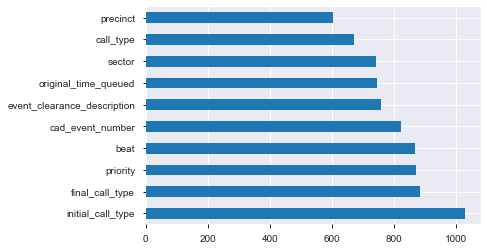

In [146]:
#what are the most important features? Looks like they are all used a fair amount, with initial_call_type coming out as the most important, which makes sense
feature_importances = pd.Series(model_lgb.feature_importances_, index=features.columns)
feature_importances.nlargest(20).plot(kind='barh')

In [ ]:
#all possible scoring metrics in sklearn
#sorted(sklearn.metrics.SCORERS.keys())

# Now Lets Make this Model Better!

In [60]:
from sklearn.pipeline import Pipeline
mapper = DataFrameMapper([('event_clearance_description', TfidfVectorizer())])

In [61]:
mapper

DataFrameMapper(default=False, df_out=False,
                features=[('event_clearance_description',
                           TfidfVectorizer(analyzer='word', binary=False,
                                           decode_error='strict',
                                           dtype=<class 'numpy.float64'>,
                                           encoding='utf-8', input='content',
                                           lowercase=True, max_df=1.0,
                                           max_features=None, min_df=1,
                                           ngram_range=(1, 1), norm='l2',
                                           preprocessor=None, smooth_idf=True,
                                           stop_words=None, strip_accents=None,
                                           sublinear_tf=False,
                                           token_pattern='(?u)\\b\\w\\w+\\b',
                                           tokenizer=None, use_idf=True,
               

In [63]:
tfidf_descriptions = mapper.fit_transform(df)

In [126]:
# Looking at all the types of incidents that occur
df.event_clearance_description.value_counts().head(30)

assistance rendered                                                    39485
report written (no arrest)                                             17578
oral warning given                                                      8398
citation issued (criminal or non-criminal)                              4947
unable to locate incident or complainant                                4337
physical arrest made                                                    4195
other report made                                                       3486
false complaint/unfounded                                               2233
no police action possible or necessary                                  1830
problem solving project                                                 1781
follow-up report made                                                   1340
citations – criminal citation issued (new incident number required)     1005
radio broadcast and clear                                                988

In [127]:
#looking at all types of priority, I am assuming that 9 = highest priority
df.priority.value_counts().sort_values()

8        1
9     1310
5     1551
6     2743
4     4272
1     8338
2    17768
7    27115
3    31079
Name: priority, dtype: int64

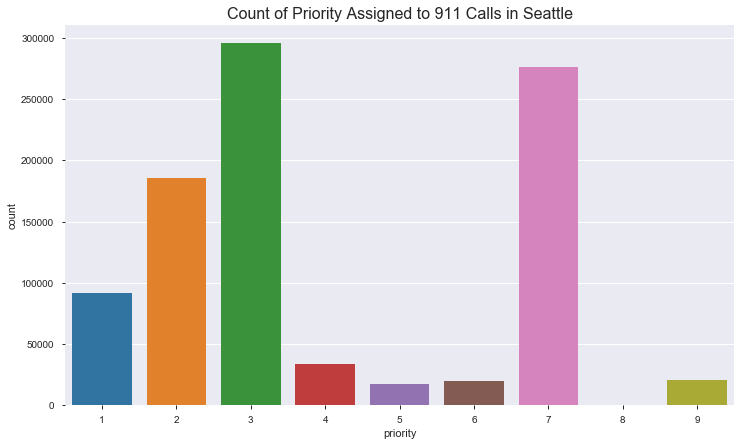

In [97]:
plt.figure(figsize = (12, 7))
sns.countplot(df['priority'])
plt.title("Count of Priority Assigned to 911 Calls in Seattle", fontsize = 16);

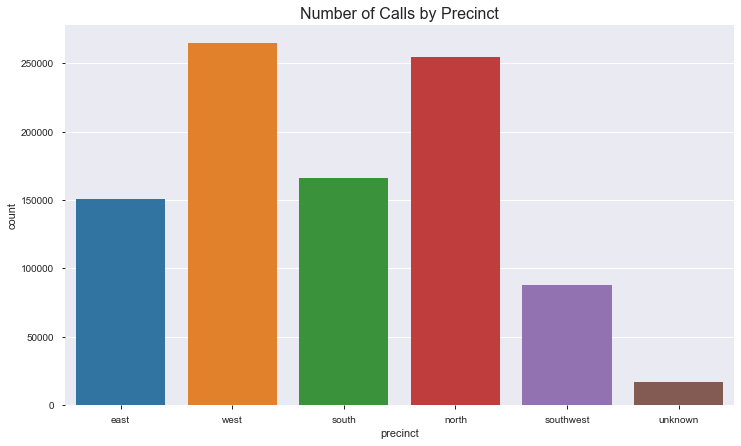

In [98]:
plt.figure(figsize = (12, 7))
sns.countplot(df['precinct'])
plt.title('Number of Calls by Precinct', fontsize = 16);

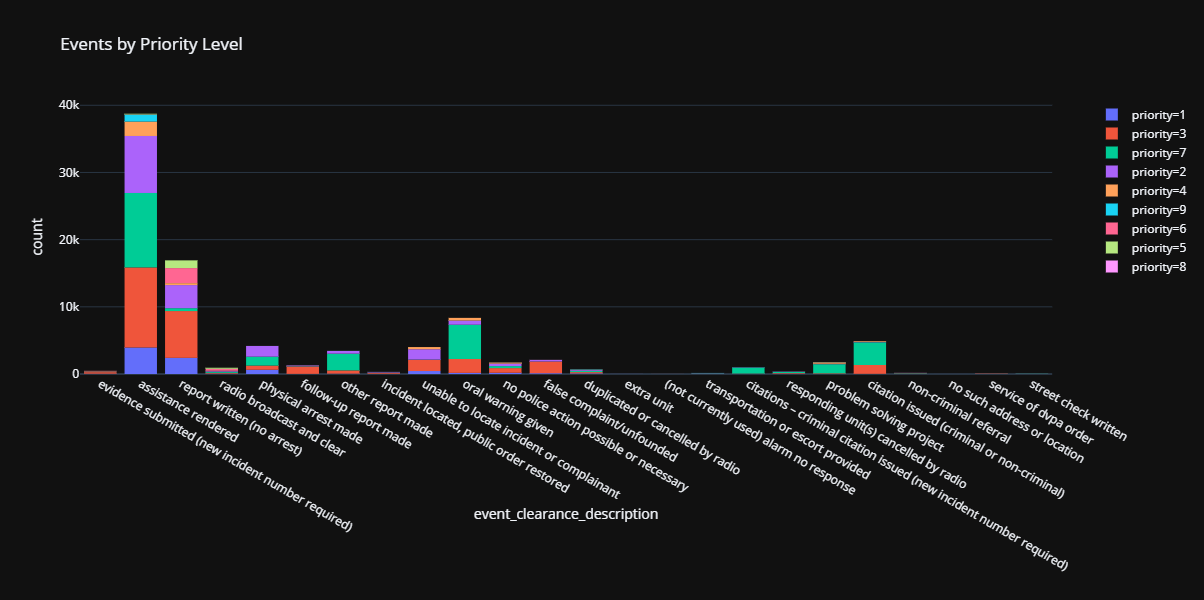

In [174]:
# now I want to visualize events by the priority of the call
px.histogram(df, x='event_clearance_description', color = 'priority', template='plotly_dark', title = 'Events by Priority Level')

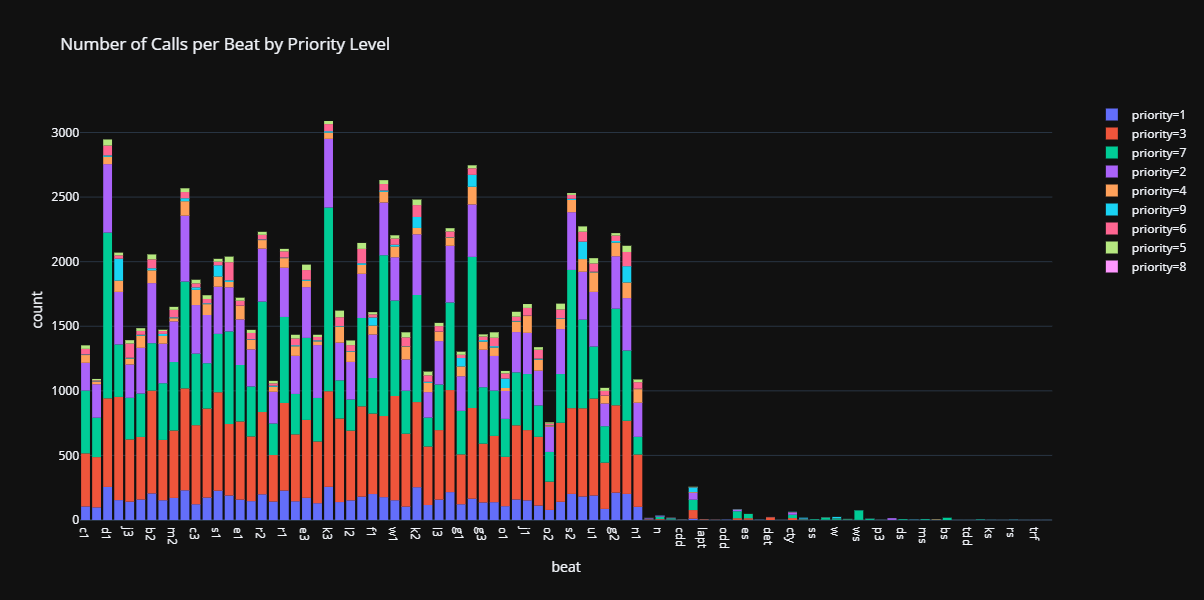

In [173]:
# now I want to visualize the number of calls per beat and priority
px.histogram(df, x='beat', color = 'priority', template='plotly_dark', title = 'Number of Calls per Beat by Priority Level')

In [285]:
# now I want to visualize the number of events by final call type (West is where I live)
#px.histogram(df, x='precinct', color = 'final_call_type', template='plotly_dark', title = 'Final Call Types per Precinct')

In [179]:
#on average, what is the priority level of precinct calls, standard deviation, and total calls perprecinct
df.groupby('precinct').priority.agg(['mean', 'std', 'size'])

mean  std   size
precinct                   
east       4.17 2.26  15527
north      3.68 2.06  24049
south      4.08 2.28  16687
southwest  3.78 2.15   9061
unknown    5.83 2.24   1313
west       4.32 2.32  25358

## Addressing Outliers
- this function and the subsequent removal of outliers have been built into the clean_df function at the beginning of this notebook, this is  simply the code I was using to explore outliers prior to building it into the cleaning process

In [71]:
def z_score_indices_of_outliers(X, threshold=3):
    '''
    Detects outliers using Z-score standardization
    
    Input: - X: A feature in your dataset
           - threshold: The number of standard deviations from the mean
                        to be considered an outlier
                        
    Output: A data frame with all outliers beyond 3 standard deviations
    '''
    X_mean = np.mean(X)
    X_stdev = np.std(X)
    z_scores = [(y - X_mean) / X_stdev for y in X]
    z_df = pd.DataFrame(z_scores)
    pos_outliers = z_df[z_df[0] > 3]
    neg_outliers = z_df[z_df[0] < -3]
    return pos_outliers; neg_outliers

In [153]:
response_time_outliers = z_score_indices_of_outliers(df['total_response_time'])

In [152]:
df.reset_index(drop = True, inplace = True)

In [154]:
response_time_outliers.head()

0
146 4.92
153 3.24
161 5.38
162 9.08
232 3.22

In [157]:
df = df.drop(response_time_outliers.index).reset_index(drop = True)

## Check out model after removing outliers
- __Removing outliers improved the model by 100%__

In [202]:
#convert datetime objects back into strings for model training
df['arrived_time'] = [datetime.strftime(x, "%b %d %Y %I:%M:%S:%f%p") for x in df['arrived_time']]
df['original_time_queued'] = [datetime.strftime(x, "%b %d %Y %I:%M:%S:%f%p") for x in df['original_time_queued']]

#select features and target
features = df.drop(['total_response_time', 'arrived_time'], axis = 1)
labels = df['total_response_time']
    
#Label Encoding
for x in features.columns[features.dtypes == 'object']:
    features[x] = features[x].factorize()[0]
    
#split training data into train and test set for validation
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = .2, random_state = 49)

#instatiate model and get results
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=2000,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

mlgbScore = get_score(model_lgb)

print(f'Scores for LightGBM Without Outliers')

print(f'{mlgbScore}')

Scores for LightGBM Without Outliers
R^2                    0.38
RMSE                1251.95
MAE                  698.18
TrainingTime(sec)      2.60
dtype: float64


In [203]:
1251/60

20.85

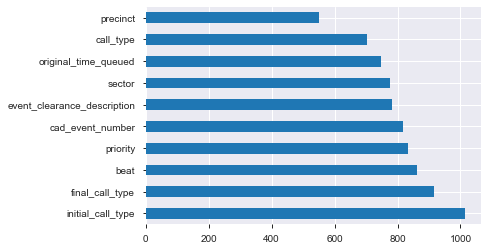

In [164]:
#what are the most important features?
feature_importances = pd.Series(model_lgb.feature_importances_, index=features.columns)
feature_importances.nlargest(20).plot(kind='barh')

## Hyperparameter Tuning with New Model

In [165]:
#instatiate model and get results
hyper_model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=2000,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

# this defines the inner cross-validation
nr.seed(1234)
inside = model_selection.KFold(n_splits=10, shuffle = True)

#this defines outer cross-validation
nr.seed(4321)
outside = model_selection.KFold(n_splits=10, shuffle = True)


## Define the dictionary for the grid search and the model object to search on
param_grid = {"n_estimators": list(range(1, 4000, 10)), 'max_depth':list(range(-1, 100, 1)), 'learning_rate': (.01, .05, .10, .50, .60, .70, .80, .90, 1)}

## Perform the grid search over the parameters
nr.seed(4465)
tuned_lgb = model_selection.RandomizedSearchCV(estimator = hyper_model_lgb, param_distributions = param_grid, 
                      cv = inside, # Use the inside folds
                      scoring = 'neg_mean_squared_error',
                      return_train_score = True)

tuned_lgb.fit(features, labels)
print(tuned_lgb.best_estimator_.n_estimators)
print(tuned_lgb.best_estimator_.max_depth)
print(tuned_lgb.best_estimator_.learning_rate)

nr.seed(478)
cv_estimate_lgb = model_selection.cross_val_score(tuned_lgb, features, labels, 
                                 cv = outside) # Use the outside folds

print('Mean RMSE = %4.3f' % cv_estimate_lgb)
print('RMSE by cv fold')
for i, x in enumerate(cv_estimate_lgb):
    print('Fold %2d    %4.3f' % (i+1, x))

RandomizedSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
                   error_score='raise-deprecating',
                   estimator=LGBMRegressor(bagging_fraction=0.8, bagging_freq=5,
                                           bagging_seed=9, boosting_type='gbdt',
                                           class_weight=None,
                                           colsample_bytree=1.0,
                                           feature_fraction=0.2319,
                                           feature_fraction_seed=9,
                                           importance_type='split',
                                           learning_rate=0.05, max_bin=55,
                                           max_depth...
                                                          1),
                                        'max_depth': [-1, 0, 1, 2, 3, 4, 5, 6,
                                                      7, 8, 9, 10, 11, 12, 13,
                             

3521
27
0.1


TypeError: only size-1 arrays can be converted to Python scalars

In [171]:
for i, x in enumerate(cv_estimate_lgb):
    print('Fold %2d     %4.3f' % (i + 1, x))

Fold  1     -1539037.924
Fold  2     -1532470.782
Fold  3     -1467297.267
Fold  4     -1617516.929
Fold  5     -1518351.369
Fold  6     -1501705.614
Fold  7     -1461752.569
Fold  8     -1624375.850
Fold  9     -1549438.958
Fold 10     -1633089.939


In [168]:
np.mean(cv_estimate_lgb)

-1544503.7201489224

In [169]:
np.sqrt(1544503)

1242.780350665394

In [170]:
1242/60

20.7

Our model has improved substantially after removing the outliers, I think the next stage will be continuing to clean the data and getting rid of 0:00:00 response times, adding in more data incrementally, as well as perhaps looking specifically into stage 1 priority calls which are the highest...

## Predicting Priority Level 1 Call Response Times
- Adding in additional data and focusing solely on priority 1 calls

In [80]:
#read in data (I wanted to add more data in thats why I am doing this again)
df = pd.read_csv('Call_Data.csv', nrows = 1000000)
top_priority_calls = clean_df(top_priority_calls)
top_priority_calls = top_priority_calls[top_priority_calls['priority'] == 1]
top_priority_calls['arrived_time'] = [datetime.strftime(x, "%b %d %Y %I:%M:%S:%f%p") for x in top_priority_calls['arrived_time']]
top_priority_calls['original_time_queued'] = [datetime.strftime(x, "%b %d %Y %I:%M:%S:%f%p") for x in top_priority_calls['original_time_queued']]

#select features and target
features = top_priority_calls.drop(['total_response_time', 'arrived_time'], axis = 1)
labels = top_priority_calls['total_response_time']
    
#Label Encoding
for x in features.columns[features.dtypes == 'object']:
    features[x] = features[x].factorize()[0]
    
#split training data into train and test set for validation
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = .2, random_state = 51)

#instatiate model and get results
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=2000,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)


#scoring function for regression
def get_score(model):
        '''
        Fits the model and returns a series containing the RMSE, MAE, and R^2
        '''
        from sklearn.metrics import mean_squared_error, mean_absolute_error
        import time

        startTime = time.time()  # Getting training time
        
        # Fits with training set
        model.fit(X_train, y_train)
        totalTime = time.time() - startTime
        predictions = model.predict(X_test)
        
        r2 = model.score(X_test, y_test)
        rmse = np.sqrt(mean_squared_error(y_test, predictions))
        mae = mean_absolute_error(y_test, predictions)
            
        score_results = pd.Series([r2, rmse, mae, totalTime], index=['R^2', 'RMSE', 'MAE', 'TrainingTime(sec)'])
        
        return score_results

mlgbScore = get_score(model_lgb)

print(f'Scores for LightGBM Without Outliers')

print(f'{mlgbScore}')

Scores for LightGBM Without Outliers
R^2                   0.06
RMSE                685.49
MAE                 368.34
TrainingTime(sec)     0.79
dtype: float64


In [78]:
top_priority_calls.head()

cad_event_number                        event_clearance_description                 call_type  priority                             initial_call_type                               final_call_type           original_time_queued                   arrived_time precinct   sector beat  total_response_time
0     2009000189335  evidence submitted (new incident number required)  telephone other, not 911         1              dist - ip/jo - dv dist - no aslt     --dv - arguments, disturbance (no arrest)  Jun 02 2009 03:35:46:000000AM  Jun 02 2009 04:09:38:000000AM     east  charlie   c1              2032.00
1     2009000189336         citation issued (criminal or non-criminal)  telephone other, not 911         3                    traffic - blocking roadway                    traffic - blocking roadway  Jun 02 2009 03:43:08:000000AM  Jun 02 2009 05:47:21:000000AM     west    queen   q1              7453.00
2     2009000189340                            problem solving project                    onview         7  premise check, officer initiated onview only  premise check, officer initiated onview only  Jun 02 2009 03:47:24:000000AM  Jun 02 2009 03:47:24:000000AM     west     king   k1                 0.00
3     2009000189341                                assistance rendered  telephone other, not 911         1    burg - ip/jo - res (incl unocc structures)      --suspicious circum. - suspicious person  Jun 02 2009 03:48:39:000000AM  Jun 02 2009 04:01:55:000000AM    south    ocean   o3               796.00
4     2009000189342                                assistance rendered  telephone other, not 911         1    burg - ip/jo - res (incl unocc structures)      --suspicious circum. - suspicious person  Jun 02 2009 03:49:37:000000AM  Jun 02 2009 04:22:28:000000AM     west    david   d1              1971.00

In [221]:
#looks like we can predict response times to top priority calls within 6 minutes, which is better than the average response time for these calls
374/60

6.233333333333333

# EDA

In [230]:
top_priority_calls.describe()

cad_event_number  priority  total_response_time
count          90522.00  90522.00             90522.00
mean   2010330614162.11      1.00               409.52
std        846891601.08      0.00               411.97
min    2009000189335.00      1.00                 0.00
25%    2010000081570.25      1.00               156.00
50%    2010000407235.00      1.00               298.00
75%    2011000230969.00      1.00               517.00
max    2012000054286.00      1.00              2725.00

In [249]:
top_priority_calls.groupby('precinct').total_response_time.agg(['mean', 'std'])

mean    std
precinct               
east      337.55 361.11
north     457.54 431.17
south     428.76 427.03
southwest 468.36 418.88
unknown   192.46 392.61
west      364.36 393.03

In [64]:
top_priority_calls.groupby('precinct').total_response_time.mean()

NameError: name 'top_priority_calls' is not defined

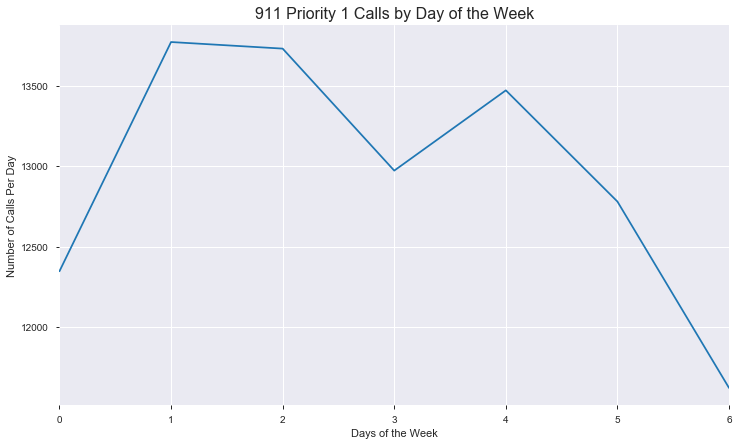

In [63]:
#looking at calls out of days of the week, looks like people don't call 911 a lot on Sunday...
df.groupby(df['original_time_queued'].dt.dayofweek).total_response_time.count().plot(figsize = (12, 7))
plt.title('911 Priority 1 Calls by Day of the Week', fontsize = 16)
plt.xlabel('Days of the Week')
plt.ylabel('Number of Calls Per Day');

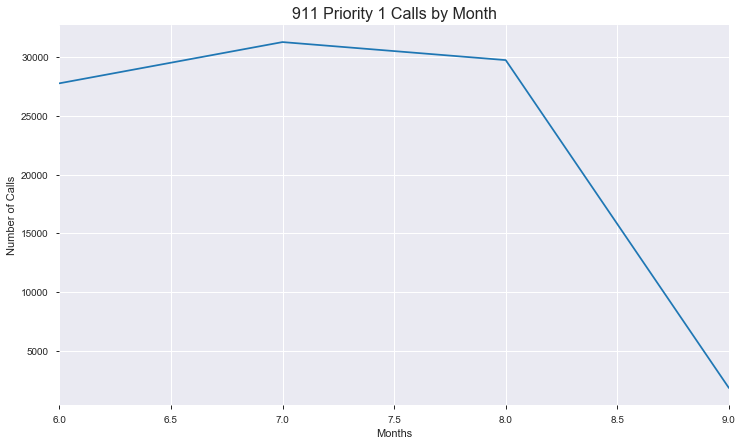

In [59]:
df.groupby(df['original_time_queued'].dt.month).total_response_time.count().plot(figsize = (12, 7))
plt.title('911 Priority 1 Calls by Month', fontsize = 16)
plt.xticks()
plt.xlabel('Months')
plt.ylabel('Number of Calls');

In [35]:
df['original_time_queued'].dt.month.unique()

array([6, 7, 8, 9], dtype=int64)